# A model for the effect of Degree of Linear Polarization on Dung Beetle Orientation Accuracy
---

## Details

&ensp;AUTHOR:&emsp;   James Foster &emsp; 2025 03 26

MODIFIED:&emsp; James Foster &emsp; 2025 03 27

DESCRIPTION:&emsp; Fit a hierarchical maximum-likelihood von Mises to honeybee waggle-run angles.
Modified from [beetles.ipynb](https://github.com/jgraving/unwrap/notebooks/)

            
INPUTS:&emsp;   `'DLdata201611.csv'`
            
OUTPUTS:&emsp;  Plots and test statistics

CHANGES: 
- Added 0.32 condition to positive control

REFERENCES:
- Foster, J.J., $et~al$.  (2019). 
Orienting to polarized light at night – matching lunar skylight to performance in a nocturnal beetle.
Journal of Experimental Biology 222, jeb188532. 
DOI:[10.1242/jeb.188532](https://doi.org/10.1242/jeb.188532)


- Sayin S, ... Graving JM, $et~al$. (2025)
The behavioral mechanisms governing collective motion in swarming locusts.
Science 387,995-1000
DOI:[10.1126/science.adq7832](https://doi.org/10.1126/science.adq7832)

- Graving JM & Foster JJ in preparation
Unwrapping Circular Statistics: Bayesian Linear Models for Circular Data

---
# TODO
- Try looser priors for max polarization condition +
- Compare circular uniform and unimodal priors +
- Combine DoLP 0.99 and 0.32 conditions
- Find appropriate priors for the 90° turn

In [1]:
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install -U --no-cache git+https://github.com/jgraving/unwrap

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jgraving/unwrap to c:\users\james foster\appdata\local\temp\pip-req-build-yzs3d0nq
  Resolved https://github.com/jgraving/unwrap to commit b158ec9cf3b6d06ed4c9baa721978c7a1ab1dd84
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=11617 sha256=d975fbd41897262af0f95d3bc704db40d6b14224b634e5238db9f97a08c8e096
  Stored in directory: C:\Users\James Foster\AppData\Local\Temp\pip-ephem-wheel-cache-2221tczn\wheels\6d\a6\84\e3cfe169b27e40b37f18ed01b9a2ce83462e4b2ccd53a02794
Successfully built unwrap


  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap 'C:\Users\James Foster\AppData\Local\Temp\pip-req-build-yzs3d0nq'


# Reorganise data for modelling
The original data was in a wide format with separate columns for the angle observed in trials 1 and 2,
as well as for the different conditions in trials 1 and 2.

Here we separate them, convert condition names to condition features, and convert angles from degrees to radians.

In [2]:
import pandas as pd
import numpy as np
from unwrap.link.numpy import shifted_modulo

# Load the file
file_path = 'DLdata201611.csv'
df_raw = pd.read_csv(file_path, sep=',')
#Columns
#night	trial1	trial2	cond1	cond2	deg.of.pol	Beetle

# Data is in wide format, convert from wide to long
df = pd.wide_to_long(df_raw,
                          stubnames= ['trial','cond'], #find columns starting with these labels
                          i = 'Beetle', #organise by beetle
                          j = 'Trial') #assign trial to a new column called "Trial"
#Convert Beetle and Trial from indices to column names
df = df.reset_index(level = ['Beetle', 'Trial']) #After conversion saves as separate index columns
# #Rename variables for BAMBI
df = df.rename(columns={'trial': 'deg_angle'}) #save output from each trial column as the angle
df = df.rename(columns={'deg.of.pol': 'DoLP'}) #capitalise DoLP
df = df.rename(columns={'night': 'Night'}) #Captitalise
df = df.rename(columns={'Beetle': 'Individual'}) #More specific name NB very likely some are the same indiv multiple times

# Specify circular data
df['RadAngle'] = np.deg2rad(df['deg_angle']) #convert to radians
# Normalize the heading radians to be between -pi and pi
df['RadAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)

# # Specify condition types by rotation angle
df['PolAngle'] = df['cond'].apply(
    lambda x: 
    0 if 'PolNorth' in x else 
     0 if 'UnpolNorth' in x else 90)
df['PolAngle_rad'] = np.deg2rad(df['PolAngle']) #convert to radians


# # Rename columns: change 'Beetle' to 'Individual'
df['Individual'] = df['Individual'].astype('category')
df['Night'] = df['Night'].astype('category')

# # Keep only the relevant columns and drop rows with missing values
df = df[['Individual', 'Trial', 'DoLP', 'PolAngle_rad', 'Night', 'RadAngle', 'deg_angle']].dropna().copy()
df.reset_index(drop=True, inplace=True)

df.head(n = 345)

,Individual,Trial,DoLP,PolAngle_rad,Night,RadAngle,deg_angle
0,1,1,0.99,0.000000,20161111,-2.094395,240
1,2,1,0.02,0.000000,20161111,2.268928,130
2,3,1,0.99,1.570796,20161111,1.047198,60
3,4,1,0.02,1.570796,20161111,-0.785398,315
4,5,1,0.99,0.000000,20161111,1.570796,90
...,...,...,...,...,...,...,...
340,1,2,0.99,1.570796,20161111,-1.919862,250
341,2,2,0.02,1.570796,20161111,-1.832596,255
342,3,2,0.99,0.000000,20161111,0.261799,15
343,4,2,0.02,0.000000,20161111,-2.007129,245


# Inspect the data

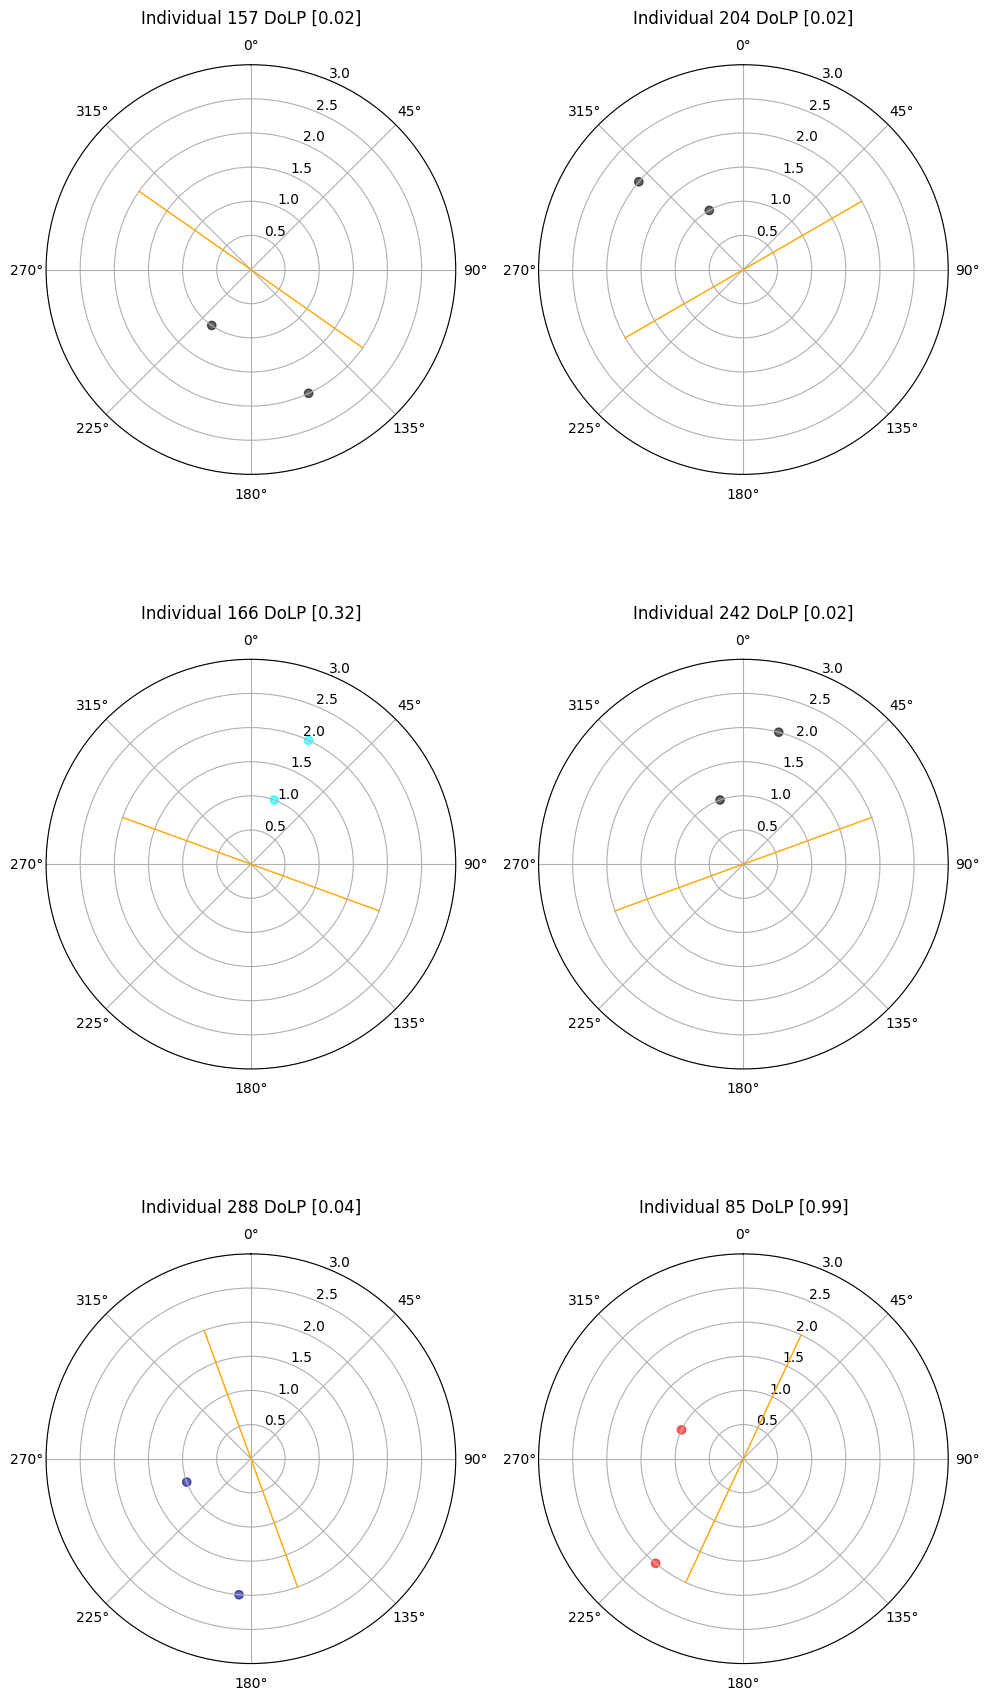

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Get unique individual IDs.
unique_individuals = df['Individual'].unique()
unique_individuals = unique_individuals[np.random.randint(low = 0, high=340, size=6)] # just six chosen randomly

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = ( np.intc(np.ceil(n_plots/2)) , 2  ) # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = np.max(df['Trial'])  # Maximum radial value (maximum runs)  # Maximum radial value

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    # Set axes to geographic format (clockwise, 0° at the top)
    ax.set_theta_direction(-1)#reverse to clockwise
    ax.set_theta_zero_location('N')#place 0° at the top

    individual_data = df[df['Individual'] == individual]
    individual_data = df[df['Individual'] == individual]
    plotcol = individual_data['DoLP'].apply(
                     lambda x: 'red' if x  == 0.99 else
                                'cyan' if x == 0.32 else
                                 'blue' if x == 0.11 else
                                 'darkblue' if x == 0.04 else
                                 'black')

    # Scatter-plot data.
    plot_scatter(ax, individual_data, 'RadAngle', 'Trial', 
                 plotcol, individual_data['DoLP'])
    #Add expected axis for 2nd trial
    ax.plot(individual_data['RadAngle'].values[0]+[-np.pi/2, np.pi/2], [radial_max, radial_max], color='orange', linewidth=1)
    
    # Plot summary statistics for each condition.
    # if not individual_data.empty:
    #     plot_summary_stats(individual_data, individual_data['RadAngle'].values, radial_max, 'gray')
    
    ax.set_title(f'Individual {individual} DoLP {np.unique(individual_data['DoLP'])}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)


plt.tight_layout()
plt.show()


# Fit a circular model with individual effects but no interactions
The model needs to predict a bimodal distribution with changes of 90° between trials 

In [4]:
# import sys
# !{sys.executable} -m pip install fastprogress
# import sys
# !{sys.executable} -m pip install ipywidgets

## First test: Positive control


In [ ]:
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior
# from unwrap.distributions import BimodalVonMises
from pymc import VonMises

from scipy.stats import circmean, circstd


#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x*2) if pd.notnull(x) else x)
df.head(n = 345)
# #1st test, condition as a categorical 
df['Cond'] = df['PolAngle_rad'].astype('category')
df_max = df[df['DoLP'] > 0.31 ] #20250327 add the 2nd most polarized condition to get more data to fit to
# Population mean as prior
condata = df[df['Cond'] == 0 ] #just the data for polarizer to the North, expect a change of +-90° (x2 = 180°) for polarizer East
mu_prior = circmean(condata['TwoAngle'])

# Define the model formula with updated, capitalized variable names.
formula = bmb.Formula(
    "TwoAngle ~ Cond + (1|Individual)",
    "kappa ~ 1 + (1|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
#20250327 a lot of divergences and high rhats
# 2 trials per individual may be insufficient to estimate individual effects in this way
priors = {
    # Fixed effects for μ:
    # "Intercept": CircularUniformPrior(), # Unbiased prior, pop mean can be in any direction
    # It is difficult to find the mean of uniformly distributed individual headings, may be better to anchor it
    "Intercept": bmb.Prior("VonMises", mu=mu_prior, kappa=10), 
    # We expect the effect of condition to be a change of 180° (2 x 90°), most priors find this fairly well
    "Cond": bmb.Prior("Normal", mu=np.pi, sigma=90*np.pi/180), #
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here; large sigma slows estimation; mu=log(30), sigma=0.1 appears to be a good compromise.
    "1|Individual": bmb.Prior(
        # Weak prior, individuals weakly clustered around pop mean
    # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(10), sigma=0.5) 
    # In these experiments, we have no expectation that beetles would choose the same direction in their 1st trial
    "VonMises", mu=0, kappa=bmb.Prior("HalfNormal", sigma=2.0) 
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # # Across two trials the MLE for this should range from ≈1.5–2.8
        #20250327 try higher precision to make individual mean directions easier to estimate
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
    },
}

# Build the model using the updated formula and priors.
model = bmb.Model(
    formula,
    df_max,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(model)

# Fit the model.
idata = model.fit(draws=500,   tune = 500,
                  init = 'auto',
                  progressbar=True) # be prepared for this to take a very long time to run on Windows!

       Formula: TwoAngle ~ Cond + (1|Individual)
                kappa ~ 1 + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 180
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ VonMises(mu: 5.961, kappa: 2.0)
            Cond ~ Normal(mu: 3.1416, sigma: 1.5708)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: HalfNormal(sigma: 2.0))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Cond, 1|Individual_kappa, 1|Individual, kappa_Intercept, kappa_1|Individual_sigma, kappa_1|Individual_offset]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 475 seconds.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics

In [17]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    idata, 
    var_names=["Intercept",
               "1|Individual_kappa",
                "Cond",
                "kappa_Intercept",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    "Cond",
                    ]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.370,0.395,-0.967,0.170,0.150,0.146,5.0,12.0,3.18
1|Individual_kappa,0.294,0.131,0.050,0.470,0.042,0.031,9.0,15.0,1.39
Cond[1.5707963267948966],3.133,0.108,2.921,-2.958,0.034,0.031,7.0,20.0,1.61
kappa_Intercept,2.171,0.218,1.766,2.508,0.075,0.055,10.0,36.0,1.39
kappa_1|Individual_sigma,0.486,0.037,0.402,0.541,0.013,0.009,9.0,27.0,1.39


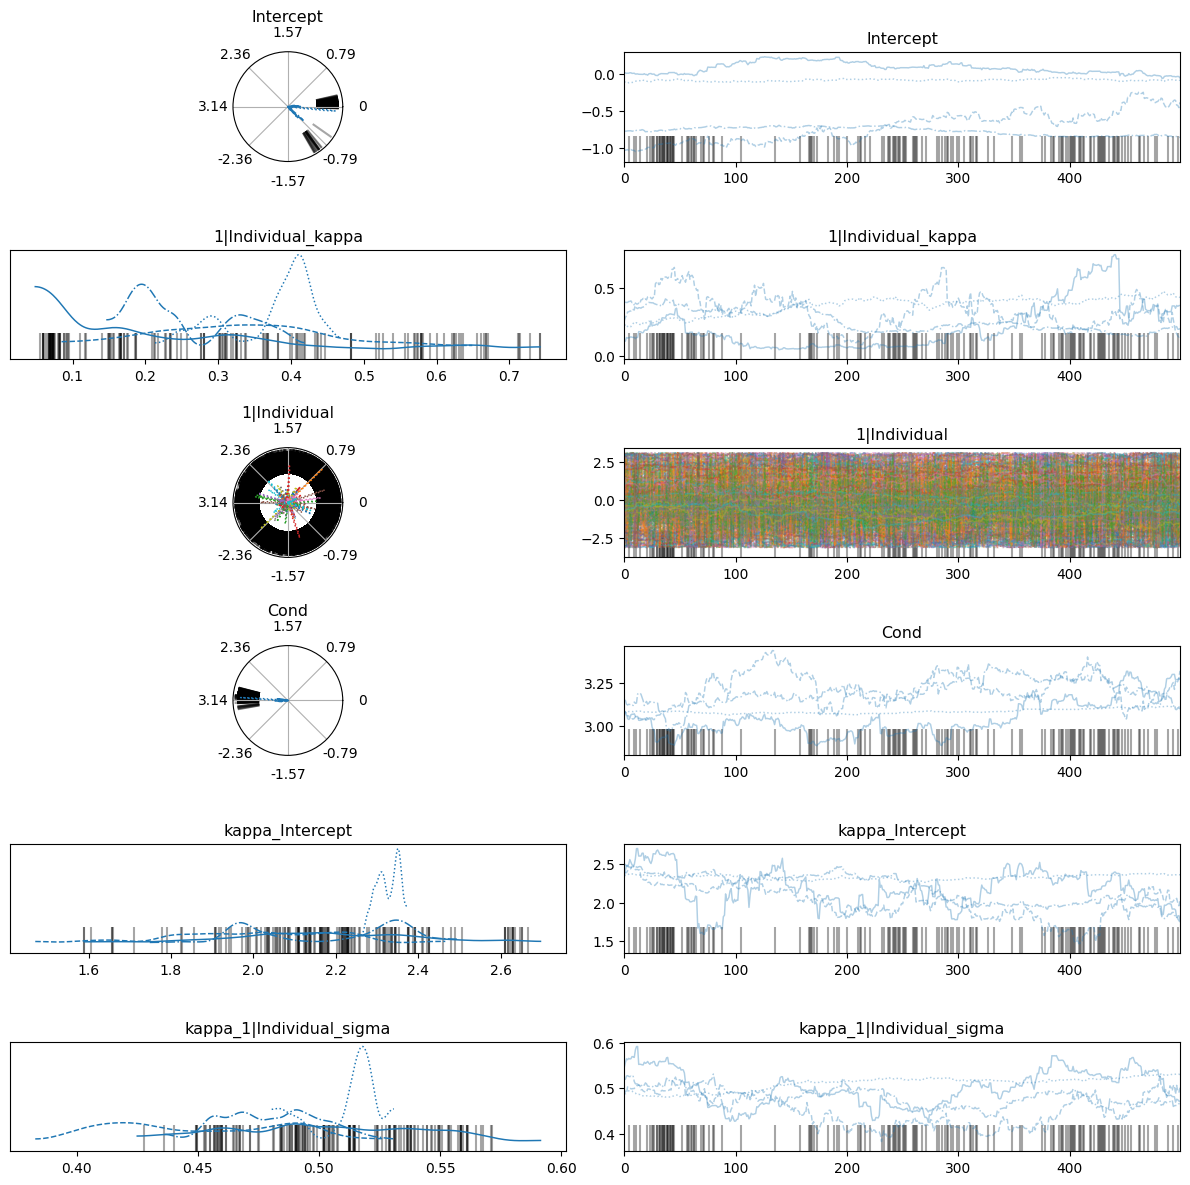

In [18]:
az.plot_trace(idata,
              var_names=["Intercept",
               "1|Individual_kappa",
               "1|Individual",
                "Cond",
                "kappa_Intercept",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    "Cond",
                    "1|Individual"
                    ]
)
plt.tight_layout()
plt.show()

In [ ]:
# #help with progressbar on Mac?
# # https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True
# import numpy as np
# import pandas as pd
# import bambi as bmb
# import arviz as az
# import matplotlib.pyplot as plt

# from unwrap.link.bambi import LINKS
# from unwrap.link.numpy import inverse_softplus
# from unwrap.prior import CircularUniformPrior
# # from unwrap.distributions import BimodalVonMises
# from pymc import VonMises

# import warnings

# from scipy.stats import circmean, circstd

# # warnings.filterwarnings("ignore", category=UserWarning)

# def NormBeta(beta):
#     np.sqrt(sin(beta)^2 + cos(beta)^2)
# link(y) = norm(beta) * cos(x - angle(beta))

# Where norm(beta) = sqrt(beta_x^2 + beta_y^2) is the gain (effect strength), and angle(beta) = atan2(beta_y, beta_x) is the offset direction in radians.
# #2nd test, doubled angles but linear predictor
# df_max = df[df['DoLP'] == 0.99]
# # Population mean as prior
# condata = df[df['Cond'] == 0 ]
# mu_prior = circmean(condata['TwoAngle'])

# # Define the model formula with updated, capitalized variable names.
# formula = bmb.Formula(
#     "TwoAngle ~ NormBeta(beta)*cos(PolAngle_rad-beta) + (1|Individual)",
#     "beta ~ 1",
#     "kappa ~ 1 + (1|Individual)",
# )

# # Specify priors for the model with capitalized keys and updated variable names.
# priors = {
#     # Fixed effects for μ:
#     # "Intercept": CircularUniformPrior(), # Unbiased prior, pop mean can be in any direction
#     "Intercept": bmb.Prior("VonMises", mu=mu_prior, kappa=30), # arbitrary intercept at pop mean
#     # "Cond": bmb.Prior("Normal", mu=0, sigma=np.pi/2), #
#     "Cond": bmb.Prior("VonMises", mu=np.pi, kappa=30), #
#     # "PolAngle_rad": bmb.Prior("Normal", mu=0, sigma=1.0), #
#     # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here; large sigma slows estimation; mu=log(30), sigma=0.1 appears to be a good compromise.
#     # "1|Night": bmb.Prior(
#     "1|Individual": bmb.Prior(
#     "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(2), sigma=0.10) # Informative prior, individuals close to pop mean circsd ~10° # do not change!
#     ),
#     # Priors for the κ-model (inside the "kappa" dictionary):
#     "kappa": {
#         # Fixed effects for κ:
#         "Intercept": bmb.Prior("Normal", mu=inverse_softplus(3), sigma=2.0), # Across two trials the MLE for this should rainge from ≈1.5–2.8
#         # "DoLP": bmb.Prior("Normal", mu=3.0, sigma=2.5), # Weak prior, changes in concentration are within 2.5 orders of magnitude
#         # Individual-level effects for κ:
#         # "1|Night": bmb.Prior(
#         "1|Individual": bmb.Prior(
#             "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
#         ),
#     },
# }

# # Build the model using the updated formula and priors.
# model = bmb.Model(
#     formula,
#     df_max,
#     family="vonmises",
#     priors=priors,
#     link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
#     center_predictors=False,
#     dropna=True,
    
# )

# print(model)

# # Fit the model.
# idata = model.fit(draws=1000,   tune = 1000,
#                   init = 'auto',
#                   progressbar=True) # be prepared for this to take a very long time to run on Windows!